In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image
import random
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [3]:
# Define transformations (Resize, Normalize, Augment)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Assuming dataset is a folder-based ImageFolder dataset
dataset1 = datasets.ImageFolder("color", transform=transform)
dataset2 = datasets.ImageFolder("grayscale", transform=transform)
dataset3 = datasets.ImageFolder("segmented", transform=transform)
dataset =dataset1 + dataset2 + dataset3

In [5]:
# Split dataset into 60% Train, 20% Validation, 20% Test
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Remaining samples go to test

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [6]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

def train_model(model_name, train_loader, val_loader, num_classes=38, num_epochs=5, lr=0.0001):
    # Select GPU device
    if not torch.cuda.is_available():
        raise RuntimeError("GPU not available. This code requires a GPU to run.")
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    print(f"\nUsing device: {device} ({gpu_name})\n")

    # Load the requested model
    model_dict = {
        "ResNet50": models.resnet50,
        "ResNet101": models.resnet101,
        "EfficientNetV2": models.efficientnet_v2_s,
        "ViT": models.vit_b_16,
        "GoogleNet": models.googlenet,
        "VGG16": models.vgg16,
        "AlexNet": models.alexnet
    }

    if model_name not in model_dict:
        raise ValueError(f"Model '{model_name}' not supported!")

    model = model_dict[model_name](pretrained=True)

    # Adjust the classifier for 38 classes
    if "resnet" in model_name.lower() or "googlenet" in model_name.lower():
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif "efficientnet" in model_name.lower():
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif "vit" in model_name.lower():
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    elif "vgg" in model_name.lower() or "alexnet" in model_name.lower():
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop with tqdm
    print(f"\nTraining {model_name} for {num_epochs} epochs...\n")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Update tqdm progress bar
            progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

        print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%")

    # Evaluation Function with PR Curve
    def evaluate_model(loader, dataset_type="Validation"):
        model.eval()
        correct, total = 0, 0
        y_true, y_pred, y_scores = [], [], []

        with torch.no_grad():
            for images, labels in tqdm(loader, desc=f"🔍 Evaluating {dataset_type} Set", leave=True):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"\n{dataset_type} Set Accuracy: {accuracy:.2f}%")
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true, y_pred))

        # 🔹 Precision-Recall Curve Plot
        y_true_one_hot = np.eye(num_classes)[y_true]  # Convert to one-hot encoding

        plt.figure(figsize=(10, 6))
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(y_true_one_hot[:, class_idx], np.array(y_scores)[:, class_idx])
            plt.plot(recall, precision, label=f'Class {class_idx}')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {dataset_type} Set')
        plt.legend()
        plt.grid()
        plt.show()

    # Evaluate on Validation and Test Set
    evaluate_model(val_loader, "Validation")
    evaluate_model(test_loader, "Testing")

    return model


In [8]:
torch.cuda.empty_cache()


Using device: cuda (NVIDIA GeForce GTX 1650)


Training AlexNet for 5 epochs...



Epoch 1/5: 100%|█████████████████████████████████████████| 3055/3055 [23:34<00:00,  2.16it/s, accuracy=88.9, loss=0.35]


Epoch 1: Loss = 0.3502, Accuracy = 88.87%


Epoch 2/5: 100%|████████████████████████████████████████| 3055/3055 [09:32<00:00,  5.34it/s, accuracy=94.4, loss=0.169]


Epoch 2: Loss = 0.1693, Accuracy = 94.44%


Epoch 3/5: 100%|████████████████████████████████████████| 3055/3055 [09:02<00:00,  5.63it/s, accuracy=95.4, loss=0.138]


Epoch 3: Loss = 0.1385, Accuracy = 95.45%


Epoch 4/5: 100%|████████████████████████████████████████| 3055/3055 [09:17<00:00,  5.48it/s, accuracy=96.2, loss=0.116]


Epoch 4: Loss = 0.1164, Accuracy = 96.16%


Epoch 5/5: 100%|████████████████████████████████████████| 3055/3055 [08:29<00:00,  5.99it/s, accuracy=96.6, loss=0.104]


Epoch 5: Loss = 0.1041, Accuracy = 96.63%


🔍 Evaluating Validation Set: 100%|████████████████████████████████████████████████| 1019/1019 [06:09<00:00,  2.76it/s]



Validation Set Accuracy: 97.25%
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       381
           1       0.99      0.98      0.99       374
           2       0.97      0.98      0.98       174
           3       0.95      1.00      0.98      1002
           4       0.99      1.00      1.00       907
           5       1.00      0.99      1.00       641
           6       1.00      0.99      0.99       500
           7       0.84      0.92      0.88       325
           8       1.00      0.99      0.99       721
           9       0.93      0.90      0.92       595
          10       1.00      0.99      0.99       706
          11       0.97      0.94      0.95       702
          12       0.95      0.98      0.97       815
          13       0.98      1.00      0.99       598
          14       1.00      1.00      1.00       267
          15       1.00      1.00      1.00      3364
          16       0.99      0.99      0.99     

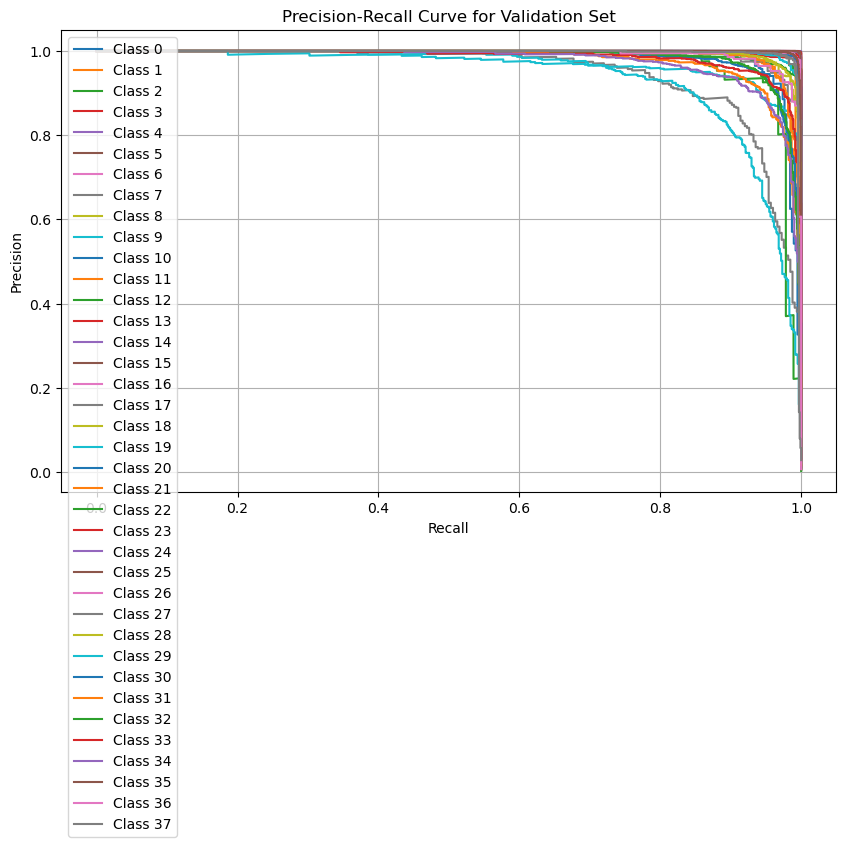

🔍 Evaluating Testing Set: 100%|███████████████████████████████████████████████████| 1019/1019 [06:01<00:00,  2.82it/s]



Testing Set Accuracy: 97.33%
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       366
           1       1.00      0.98      0.99       370
           2       0.96      0.98      0.97       154
           3       0.95      0.99      0.97      1042
           4       0.99      1.00      0.99       897
           5       0.99      0.99      0.99       632
           6       1.00      0.99      1.00       516
           7       0.84      0.92      0.88       280
           8       0.99      0.98      0.99       689
           9       0.93      0.93      0.93       596
          10       1.00      0.99      0.99       649
          11       0.99      0.93      0.96       736
          12       0.94      0.99      0.96       848
          13       0.98      1.00      0.99       655
          14       1.00      1.00      1.00       238
          15       1.00      1.00      1.00      3235
          16       0.99      0.99      0.99      13

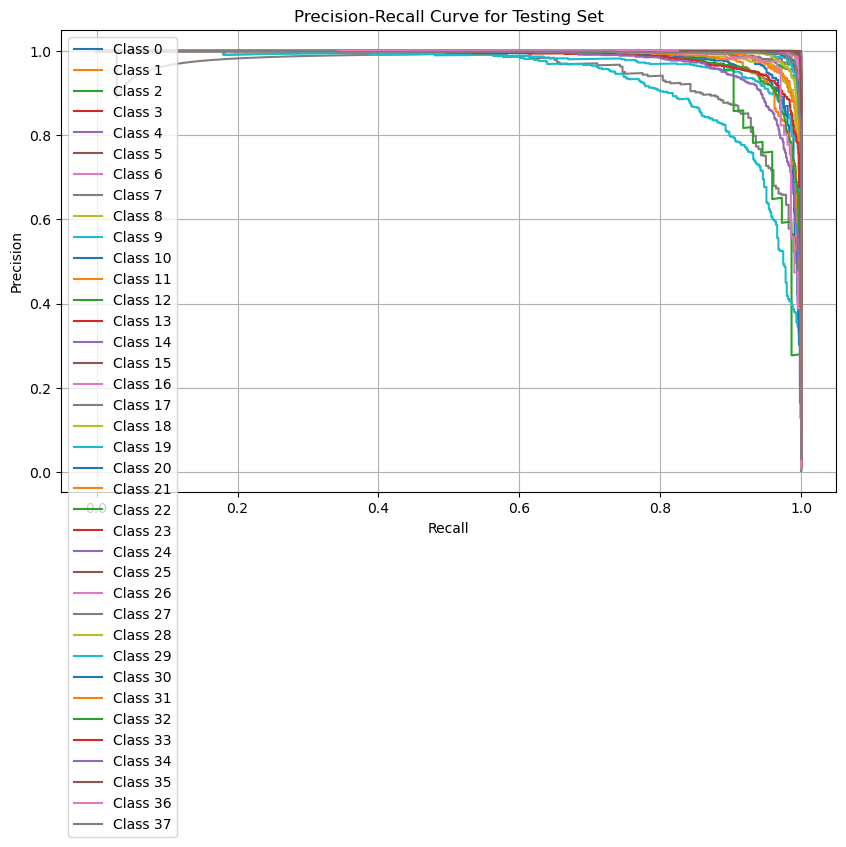

In [16]:
# Example usage
trained_model = train_model("AlexNet", train_loader, val_loader, num_classes=38, num_epochs=5, lr=0.0001)

In [ ]:
trained_model = train_model("GoogleNet", train_loader, val_loader, num_classes=38, num_epochs=5, lr=0.0001)


Using device: cuda (NVIDIA GeForce GTX 1650)


Training GoogleNet for 5 epochs...



Epoch 1/5: 100%|██████████████████████████████████████████| 3055/3055 [18:23<00:00,  2.77it/s, accuracy=92, loss=0.312]


Epoch 1: Loss = 0.3117, Accuracy = 92.01%


Epoch 2/5:  82%|████████████████████████████████▏      | 2520/3055 [12:09<02:34,  3.47it/s, accuracy=97.6, loss=0.0623]